In [325]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

In [326]:
# Definir el tamaño del dataset
data_size = 5000

# Crear un DataFrame con características y valores nulos
df = pd.DataFrame({
    'feature1': np.random.randn(data_size),
    'feature2': np.random.randn(data_size),
    'feature3': np.random.randn(data_size),
    'feature4': np.random.randn(data_size),
    'feature5': np.random.choice(['manzana', 'pera', 'uva'], size=data_size),
    'feature6': np.random.choice(['rojo', 'verde', 'azul'], size=data_size),
    'target': np.random.choice([0, 1], size=data_size)
})

# Introducir valores nulos en características numéricas y categóricas
nan_indices_num = np.random.choice(data_size, size=1000, replace=False)
df.loc[nan_indices_num[:500], 'feature1'] = np.nan
df.loc[nan_indices_num[500:], 'feature2'] = np.nan

nan_indices_cat = np.random.choice(data_size, size=500, replace=False)
df.loc[nan_indices_cat[:250], 'feature5'] = np.nan
df.loc[nan_indices_cat[250:], 'feature6'] = np.nan

# Mostrar el dataset con valores nulos
print("Dataset con valores nulos:")
print(df.head(10))

Dataset con valores nulos:
   feature1  feature2  feature3  feature4 feature5 feature6  target
0  0.039722       NaN -1.342299 -0.656241      uva     azul       1
1 -3.554395       NaN  0.376662  0.569326     pera     azul       1
2  0.652670       NaN -0.363008  2.009284     pera     rojo       0
3  0.842030  1.241013  2.233716 -0.553810      NaN     rojo       0
4  0.492114 -0.679928  0.019188 -2.208284     pera     rojo       0
5 -1.451328 -2.541110  2.295262  0.554386      uva    verde       1
6  1.489576  0.271004  1.032902 -0.833409      uva    verde       0
7  1.139064  1.830004  1.823030  1.603729     pera    verde       1
8 -0.598513 -1.586677 -0.569799  1.021037      uva    verde       0
9 -1.641693 -0.948566  0.653135 -1.348841      uva     azul       1


In [327]:
df2 = df.copy()
print('Número de observaciones (filas) = {}'.format(df2.shape[0]))
print('Total de variables disponibles (columnas) = {} '.format(df2.columns.shape[0]))
print('Columnas que cuentan con un valor nulo -')
print(df2.isnull().sum())

Número de observaciones (filas) = 5000
Total de variables disponibles (columnas) = 7 
Columnas que cuentan con un valor nulo -
feature1    500
feature2    500
feature3      0
feature4      0
feature5    250
feature6    250
target        0
dtype: int64


In [328]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature1  4500 non-null   float64
 1   feature2  4500 non-null   float64
 2   feature3  5000 non-null   float64
 3   feature4  5000 non-null   float64
 4   feature5  4750 non-null   object 
 5   feature6  4750 non-null   object 
 6   target    5000 non-null   int32  
dtypes: float64(4), int32(1), object(2)
memory usage: 254.0+ KB


*0 < |𝑟| < 0.3: Correlación débil. La relación entre las variables es débil.*

*𝑟 = -0.1: Una correlación negativa débil.*

*En esta matriz de correlación, quiere decir que cada columna es independiente entre si*

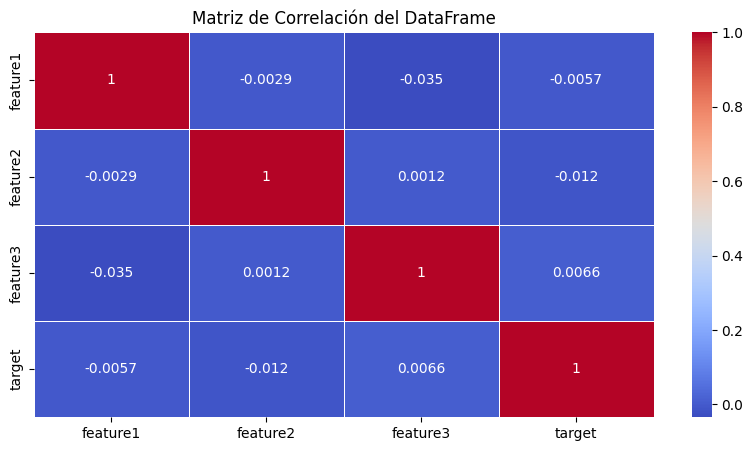

In [329]:
corr_matrix = df2[['feature1','feature2','feature3','target']].corr()
plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación del DataFrame')
plt.show()


# Cambiar valores categoricos

In [330]:
diccionario = {'manzana': 1, 'pera': 2, 'uva': 3, 'rojo': 1, 'verde': 2, 'azul': 3}

df2['feature5'] = df2['feature5'].map(diccionario)
df2['feature6'] = df2['feature6'].map(diccionario)

In [331]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature1  4500 non-null   float64
 1   feature2  4500 non-null   float64
 2   feature3  5000 non-null   float64
 3   feature4  5000 non-null   float64
 4   feature5  4750 non-null   float64
 5   feature6  4750 non-null   float64
 6   target    5000 non-null   int32  
dtypes: float64(6), int32(1)
memory usage: 254.0 KB


In [332]:
df2.isnull().sum()

feature1    500
feature2    500
feature3      0
feature4      0
feature5    250
feature6    250
target        0
dtype: int64

# K vecinos más cercanos

In [333]:
# Imputar valores nulos en características binarias usando KNN
knn_imputer = KNNImputer(n_neighbors=2)
df2[['feature1','feature2','feature3','feature4','feature5','feature6']] = knn_imputer.fit_transform(df2[['feature1','feature2','feature3','feature4','feature5','feature6']]).round()
print(df2)

      feature1  feature2  feature3  feature4  feature5  feature6  target
0          0.0      -1.0      -1.0      -1.0       3.0       3.0       1
1         -4.0       1.0       0.0       1.0       2.0       3.0       1
2          1.0      -1.0      -0.0       2.0       2.0       1.0       0
3          1.0       1.0       2.0      -1.0       2.0       1.0       0
4          0.0      -1.0       0.0      -2.0       2.0       1.0       0
...        ...       ...       ...       ...       ...       ...     ...
4995       1.0      -1.0       1.0      -1.0       3.0       1.0       1
4996       0.0       0.0       0.0       2.0       1.0       3.0       0
4997       0.0       0.0      -1.0       1.0       3.0       3.0       1
4998      -1.0      -1.0       1.0       0.0       2.0       1.0       1
4999       1.0       0.0       0.0       0.0       2.0       3.0       1

[5000 rows x 7 columns]


# 

In [334]:
df2.isnull().sum()

feature1    0
feature2    0
feature3    0
feature4    0
feature5    0
feature6    0
target      0
dtype: int64

In [335]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature1  5000 non-null   float64
 1   feature2  5000 non-null   float64
 2   feature3  5000 non-null   float64
 3   feature4  5000 non-null   float64
 4   feature5  5000 non-null   float64
 5   feature6  5000 non-null   float64
 6   target    5000 non-null   int32  
dtypes: float64(6), int32(1)
memory usage: 254.0 KB


# OneHotEncoder

In [336]:
# One-Hot Encoding para características categóricas
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
cat_encoded = ohe.fit_transform(df2[['feature5','feature6']])
cat_encoded_df = pd.DataFrame(cat_encoded, columns=ohe.get_feature_names_out(['feature5','feature6']))

# Combinar con el DataFrame original sin la columna categórica original
df_combined = pd.concat([df2.drop(columns=['feature5','feature6']), cat_encoded_df], axis=1)
df2 = df_combined

In [337]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   feature1      5000 non-null   float64
 1   feature2      5000 non-null   float64
 2   feature3      5000 non-null   float64
 3   feature4      5000 non-null   float64
 4   target        5000 non-null   int32  
 5   feature5_1.0  5000 non-null   float64
 6   feature5_2.0  5000 non-null   float64
 7   feature5_3.0  5000 non-null   float64
 8   feature6_1.0  5000 non-null   float64
 9   feature6_2.0  5000 non-null   float64
 10  feature6_3.0  5000 non-null   float64
dtypes: float64(10), int32(1)
memory usage: 410.3 KB


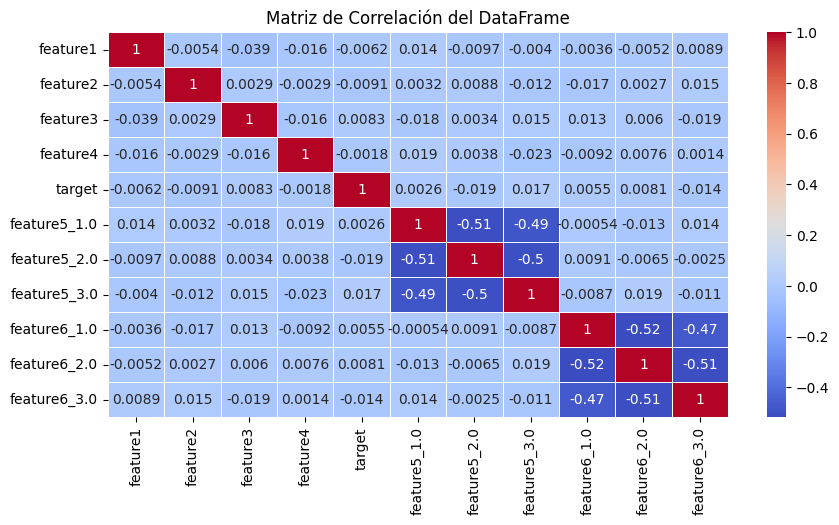

In [338]:
corr_matrix = df2[['feature1','feature2','feature3','feature4','target','feature5_1.0','feature5_2.0','feature5_3.0','feature6_1.0','feature6_2.0','feature6_3.0']].corr()
plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación del DataFrame')
plt.show()